In [33]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
#%matplotlib
from scipy.ndimage import convolve as conv2

%matplotlib inline

# TP2


### Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

#### 1- Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

## Filtros en el dominio espectral

#### Cargo imagen

In [34]:
# leo la imagen en escala de grises
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)


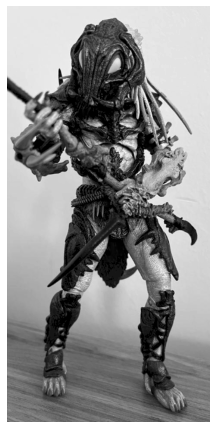

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')


### Definimos los filtros en el dominio espectral

In [36]:
print(img.shape)
h, w = img.shape


(698, 341)


### Definimos la función "create_gauss_filter"
##### inputs (height, width, k_size, sigma)
##### output (Kernel gaussiano, kernel gaussiano espectral c/adición de padding)

In [37]:
def create_gauss_filter(h, w, k_size=15, sigma=5):

    #**************************************************************************************
    # Creamos un núcleo Gaussiano unidimensional
    kX = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    kY = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    # Sumo ambos array y hago la transpuesta en X, para con "Broadcasting" generar la matriz K_sizexK_size
    #k = kX + kY.T  #Prueba de generar Kernel por la suma, no funciono

    #Generación de Kernel Gaussiano cuadrado
    #k= kX * kX.T
    k= np.multiply(kX,kX.T)
    #k = np.dot(kX,kX.T)

    # Genero el padding con la funcion np.pad
    # NOTAR, para una corrrecta dimension agrego el "resto" a la altura u ancho
    if (h > k_size) and (w > k_size):
        top_bottom = (h-k_size)//2
        add_h = (h-k_size)%2
        left_right = (w-k_size)//2
        add_w = (w-k_size)%2
        #Agrego padding al kernel
        kernel_t = np.pad(k, ((top_bottom + add_h,top_bottom),(left_right + add_w ,left_right)), mode = 'constant')
    else:
        print ('kernel dimension error')
    # Verifico la correcta dimensión
    #print(Kernel.shape)
    #***************************************************************************************
    Kernel_tf = np.fft.fft2(kernel_t)
    # Retorno el filtro Gaussiano(kernel_t) y su transformada(Kernel_tf)
    return  k, Kernel_tf

###### Verifico en imagen el kernel gaussiano y espectral

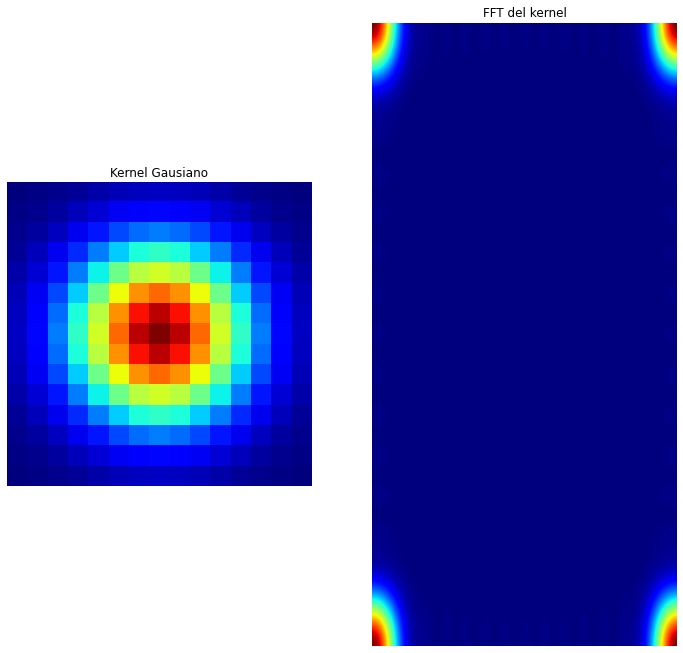

In [38]:
kernel_conv, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel_conv, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

###### Aplico el filtro espectral a la imagen

Text(0.5, 1.0, 'Desenfoque gausiano')

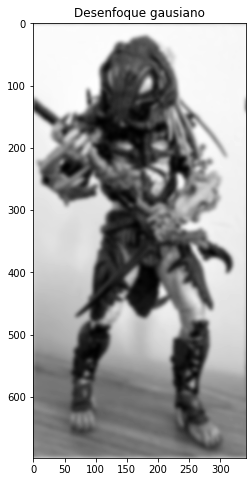

In [39]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

#img_gauss = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
img_gauss = np.uint8(np.fft.ifftshift(np.real(np.fft.ifft2(filtered))))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')

#### 2- Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

###### Defino la función "Image_quality_Measure"

In [40]:
def Image_Quality_Measure(image):
    h, w = image.shape
    F = np.fft.fft2(image)
    Fc =  np.fft.fftshift(F)
    AF = np.abs(Fc)
    M = np.max(AF)
    #th = np.count(F > (h/1000))
    th = np.count_nonzero(F > (h/1000))
    FM = th/(h*w)
    return FM

###### Realizo el filtrado por convolución con el kernel gausssiano, con kernel tamaño k_size x k_size

In [41]:
# Realizo la convolución de mi filtro gaussiano (Kernel_conv) generado anteriormente con la imagen original(img)
#image_conv =conv2(img, kernel_conv, mode='reflect')
def conv_gauss(img, K_size=15, sigma=3):
    image = cv.GaussianBlur(img,(K_size,K_size),sigma)
    return image


In [42]:
image_conv = conv_gauss(img, K_size=15, sigma=3)

#### Comparación de filtrado image_conv(convolución) VS img_gauss(espectral)

In [43]:
print(img.dtype)
print(img_gauss.dtype)
print(image_conv.dtype)

uint8
uint8
uint8


In [44]:
a = Image_Quality_Measure(img)
b = Image_Quality_Measure(img_gauss)
c = Image_Quality_Measure(image_conv)
print('Imagen original: ',a)
print('img_gauss(espectral): ',b)
print('image_conv(convolución): ',c)

Imagen original:  0.5021468964532094
img_gauss(espectral):  0.49771865993328235
image_conv(convolución):  0.4948785385979212


###### Teniendo como referencia la imagen original, se puede apreciar como la convolucion gaussiana desenfoca gradualmente y la espectral muy levemente.

#### Imagenes para comparar el desenfoque original vs conv_gausssiano

Text(0.5, 1.0, 'original')

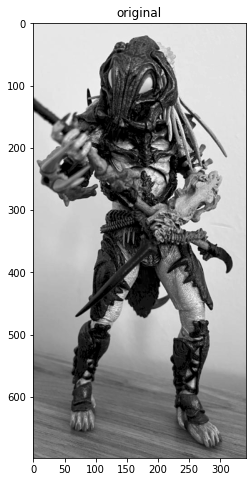

In [45]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.title('original')

Text(0.5, 1.0, 'convolucion')

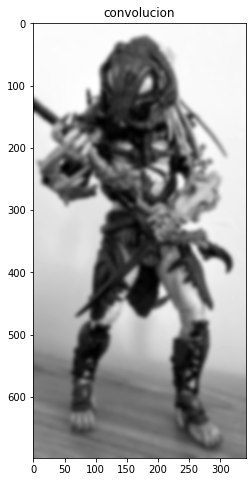

In [46]:
plt.figure(figsize=(8,8))
plt.imshow(image_conv, cmap='gray')
plt.title('convolucion')

#### 3- Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

###### Modiﬁed Laplacian (LAP2)

In [47]:
def LAP2(img):
    h,w = img.shape
    kernel_Lx = np.array([-1, 2, -1]) # kernel_Ly = kernel_Lx.T
    #Calculamos los modulos de la convolucion img*Kernel
    laplacian_X = np.abs(cv.filter2D(img, -1, kernel_Lx))
    laplacian_Y = np.abs(cv.filter2D(img, -1, kernel_Lx.T))
    Am_I= laplacian_X + laplacian_Y
    Ami = np.sum(Am_I)/(h*w)
    return Ami

#### Medidas de la calidad del foco entre las imagenes original, espectral y gaussiana por convolucion.
 El algoritmo LP2 "Laplaciano modificado" mide la cantidad de contornos en la imagen.

In [48]:
print('Modiﬁed Laplacian imagen_original', LAP2(img))
print('Modiﬁed Laplacian imagen espectral', LAP2(img_gauss))
print('Modiﬁed Laplacian imagen realizada por convolución', LAP2(image_conv))

Modiﬁed Laplacian imagen_original 9.89941937164416
Modiﬁed Laplacian imagen espectral 0.8518263324622507
Modiﬁed Laplacian imagen realizada por convolución 0.7264156492366124


##### Teniendo como referencia la imagen original, perdemos contorno con la imagen desenfocada de convolucion a comparción que en filtrado espectral